In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [14]:
df = pd.read_csv('used car data with other.csv')

In [15]:
df.columns

Index(['price', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer',
       'transmission', 'drive', 'size', 'type', 'age'],
      dtype='object')

In [16]:
df.head()

,price,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,size,type,age
0,9500,chrysler,excellent,6 cylinders,gas,30376.0,automatic,fwd,mid-size,mini-van,18.0
1,18250,toyota,good,6 cylinders,gas,201300.0,manual,4wd,full-size,offroad,13.0
2,6800,other,excellent,6 cylinders,diesel,180000.0,automatic,rwd,full-size,bus,16.0
3,2500,other,good,6 cylinders,gas,47000.0,manual,rwd,full-size,pickup,55.0
4,4000,jeep,good,6 cylinders,gas,281000.0,automatic,rwd,mid-size,SUV,15.0


In [20]:
from sklearn.preprocessing import LabelEncoder

cat_columns = ['manufacturer', 'condition', 'cylinders', 'fuel', 'transmission', 'drive', 'size', 'type']

for col in cat_columns:
    if col in df.columns:
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))

In [21]:
df.head()

,price,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,size,type,age
0,9500,8,0,5,2,30376.0,0,1,2,5,18.0
1,18250,39,2,5,2,201300.0,1,0,1,6,13.0
2,6800,31,0,5,0,180000.0,0,2,1,1,16.0
3,2500,31,2,5,2,47000.0,1,2,1,8,55.0
4,4000,19,2,5,2,281000.0,0,2,2,0,15.0


In [22]:
y = df['price']
X = df.drop(columns='price')

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [27]:
def model_selection(X_train, y_train, X_test, y_test, models):
    
    from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score
    
    R2_result = []
    MSE_result = []
    str_models = []
    
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        MSE = mean_squared_error(y_test, y_pred)
        R2 = r2_score(y_test, y_pred)       
        R2_result.append(R2)
        MSE_result.append(MSE)  
        str_models.append(str(model))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

    ax1.plot(R2_result)
    ax1.set_ylabel('R2_score')


    ax2.plot(str_models,np.sqrt(MSE_result))
    ax2.set_ylabel('RMSE_result')
    ax2.set_xticklabels(str_models, rotation=90)
    plt.tight_layout()
    
    return pd.DataFrame({'models':models, 'R2':R2_result, 'RMSE':np.sqrt(MSE_result)}) 

,models,R2,RMSE
0,LinearRegression(),0.204244,8008.263122
1,Ridge(),0.204246,8008.256016
2,Lasso(),0.204286,8008.052592
3,BayesianRidge(),0.204284,8008.062836
4,SVR(),0.001867,8968.972933
5,KNeighborsRegressor(),0.705696,4870.194552
6,DecisionTreeRegressor(),0.596954,5699.358978
7,"(DecisionTreeRegressor(max_features='auto', ra...",0.775905,4249.763402
8,"(DecisionTreeRegressor(max_depth=3, random_sta...",0.254403,7751.764820
9,([DecisionTreeRegressor(criterion='friedman_ms...,0.744459,4538.153285


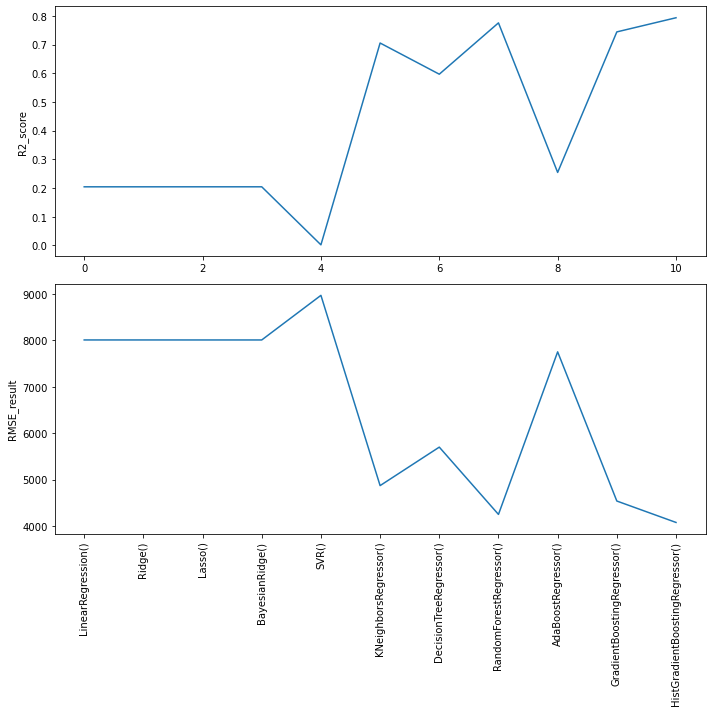

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

models = [LinearRegression(), Ridge(), Lasso(), BayesianRidge(), SVR(), KNeighborsRegressor(),
          DecisionTreeRegressor(), RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(),
          HistGradientBoostingRegressor()]

model_selection(X_train, y_train, X_test, y_test, models)   

In [29]:
def model_randomCV(X, y):
    
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.ensemble import RandomForestRegressor
    
    model_parameter = {'model':RandomForestRegressor(), 'parameters':{'n_estimators': np.arange(100, 1000, 10),
                                                                              'max_features':['auto', 'sqrt'], 
                                                                              'max_depth':np.arange(10,110, 10)}}
    
    randCV = RandomizedSearchCV(estimator=model_parameter['model'], param_distributions=model_parameter['parameters'], cv=5)
    randCV.fit(X, y)
    
    print('best_parameters: ' + str(randCV.best_params_))
    print('best_score: ' + str(randCV.best_score_))

In [30]:
model_randomCV(X, y)

best_parameters: {'n_estimators': 340, 'max_features': 'sqrt', 'max_depth': 40}
best_score: 0.7724885116915412
